In [1]:
using Revise
using Bilevel

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots
using LinearAlgebra
using StaticArrays
using BenchmarkTools
using LaTeXStrings

┌ Info: Precompiling Bilevel [9688c538-179f-11e9-3174-495cea6b7f67]
└ @ Base loading.jl:1186


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Error: evaluation error
│   mod = Bilevel
│   ex = const usrfun = #= /home/blandry/.julia/dev/Bilevel/src/solvers/snopt.jl:154 =# @cfunction(objcon_wrapper, Cvoid, (Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ptr{Cchar}, Ref{Clong}, Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}))
│   exception = (ErrorException("invalid lookup expr (\$(QuoteNode(Core.svec)))(JuliaInterpreter.SSAValue(2), JuliaInterpreter.SSAValue(3), JuliaInterpreter.SSAValue(4), JuliaInterpreter.SSAValue(5), JuliaInterpreter.SSAValue(6), JuliaInterpreter.SSAValue(7), JuliaInterpreter.SSAValue(8), JuliaInterpreter.SSAValue(9), JuliaInterpreter.SSAValue(10), JuliaInterpreter.SSAValue(11), JuliaInterpreter.SSAValue(12), JuliaInterpreter.SSAValue(13), JuliaInterpreter.SSAValue(14), JuliaInterpreter.SSAValue(15), JuliaInterpreter.SSAValue(16))"), Union{Ptr{Nothing}, InterpreterIP}[Ptr{Nothing} @0x00007f678e95d5eb, Ptr{Nothing} @0x00007f678e92e204, P

# Simulation of sliding box

In [ ]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

In [ ]:
N = 25
Δt = 0.05
# q0 = [0., 0., 0.]
q0 = [0., 0.2, 0.]
v0 = [10., 0., 0.];

In [ ]:
# Indirect

sim_data = get_sim_data_indirect(mechanism,env,Δt,relax_comp=true)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
@benchmark sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
setanimation!(mvis, sim_indirect[6], sim_indirect[1])

In [ ]:
# Direct

sim_data = get_sim_data_direct(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
@benchmark sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
setanimation!(mvis, sim_direct[6], sim_direct[1])

In [ ]:
j = 2
plot(sim_indirect[6],sim_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=0,marker=6)
plot!(sim_direct[6],sim_direct[8][j,:],label="Direct",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=4)

In [ ]:
sim_indirect[1][end]

# Trajectory optimization of sliding box

In [2]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

In [12]:
# q1 = [0., 0., 0.]
# qN = [4.85, 0., 0.]
q1 = [0., 0.2, 0.]
qN = [5.05, 0., 0.]

# N = 25
N = 20
Δt = 0.05

q_min = [-10., -10., -10.]
q_max = [10., 10., 10.]

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    add_box_con_snopt!(x_min, x_max, sim_data, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)

    x_min, x_max
end

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, length(q1), x -> vs(x, :q1) - q1)
    add_eq!(sim_data, :cv1, 1, x -> vs(x, :v1)[2])
    add_eq!(sim_data, :cqN, 2, x -> vs(x, Symbol("q", N))[1:2] - qN[1:2])
    add_eq!(sim_data, :cvN, 1, x -> vs(x, Symbol("v", N))[1])
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        x0[sim_data.vs(Symbol("q", n))] .= n/N*(qN - q1) + q1
    end
    
    x0
end

get_prob_init (generic function with 1 method)

In [13]:
# Indirect
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=true)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)

@time traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

Finished successfully: optimality conditions satisfied
 29.480044 seconds (84.78 M allocations: 8.507 GiB, 16.68% gc time)


(Array{Float64,1}[[0.0, 0.2, 0.0], [0.534192, 0.175542, -0.0826732], [1.06858, 0.126708, -0.165346], [1.60315, 0.0535822, -0.24802], [2.08627, 2.18535e-17, -0.330693], [2.47786, 0.0, -0.413366], [2.84126, 3.33163e-5, -0.496039], [3.17674, -4.15644e-5, -0.578712], [3.48414, 0.0, -0.661386], [3.76353, 0.00016858, -0.744059], [4.01557, 0.0, -0.826732], [4.23977, 9.80838e-19, -0.909405], [4.43642, 8.60533e-19, -0.992078], [4.60563, -2.18029e-6, -1.07475], [4.74741, 6.19721e-5, -1.15742], [4.86206, 2.49845e-5, -1.2401], [4.94959, -3.79118e-5, -1.32277], [5.00995, -1.58954e-18, -1.40544], [5.04341, 0.0, -1.48812], [5.05, 0.0, -1.57079]], Array{Float64,1}[[10.6799, 0.0, -1.65346], [10.6877, 0.394765, -1.65346], [10.7027, 0.795781, -1.65346], [10.7233, 1.20682, -1.65346], [9.48674, 2.12376, -1.65346], [7.17226, 3.14603, -1.65346], [6.39176, 3.45979, -1.65346], [5.61787, 3.66853, -1.65346], [4.85102, 3.77673, -1.65346], [4.10887, 3.78704, -1.65346], [3.41659, 3.70641, -1.65346], [2.75412, 3.538

In [14]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

BenchmarkTools.Trial: 
  memory estimate:  279.77 MiB
  allocs estimate:  1619012
  --------------
  minimum time:     218.541 ms (0.00% GC)
  median time:      221.410 ms (0.00% GC)
  mean time:        221.646 ms (0.00% GC)
  maximum time:     228.565 ms (0.00% GC)
  --------------
  samples:          23
  evals/sample:     1

In [16]:
# Semidirect
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)
@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

Finished successfully: optimality conditions satisfied
  0.928346 seconds (8.75 M allocations: 1.166 GiB)


(Array{Float64,1}[[0.0, 0.2, 0.0], [0.491193, 0.175734, 0.0826735], [0.978705, 0.127284, 0.165347], [1.46255, 0.0547317, 0.24802], [1.9073, 1.04012e-13, 0.330694], [2.28175, 0.0, 0.413367], [2.63232, 0.0, 0.496041], [2.95907, 0.0, 0.578714], [3.26203, 0.0, 0.661388], [3.54122, 0.0, 0.744061], [3.79685, -6.61744e-24, 0.826735], [4.029, 1.75984e-19, 0.909408], [4.23775, 0.0, 0.992082], [4.42316, 0.0, 1.07476], [4.58533, -3.58116e-19, 1.15743], [4.72432, -8.49453e-14, 1.2401], [4.8402, 9.96696e-17, 1.32278], [4.93306, 2.96294e-13, 1.40545], [5.00297, 0.0, 1.48812], [5.05, 0.0, 1.5708]], Array{Float64,1}[[9.89782, 0.0, 1.65347], [9.75023, -1.29491, 1.65347], [9.45777, -2.56062, 1.65347], [9.02465, -3.7822, 1.65347], [8.05762, -3.92353, 1.65347], [6.85823, -3.0083, 1.65347], [6.16632, -3.33705, 1.65347], [5.47082, -3.57426, 1.65347], [4.78161, -3.72167, 1.65347], [4.10811, -3.78178, 1.65347], [3.46268, -3.76147, 1.65347], [2.85179, -3.66398, 1.65347], [2.28346, -3.49509, 1.65347], [1.76497,

In [17]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

BenchmarkTools.Trial: 
  memory estimate:  93.90 MiB
  allocs estimate:  508335
  --------------
  minimum time:     56.478 ms (0.00% GC)
  median time:      92.758 ms (0.00% GC)
  mean time:        105.333 ms (0.00% GC)
  maximum time:     349.140 ms (0.00% GC)
  --------------
  samples:          48
  evals/sample:     1

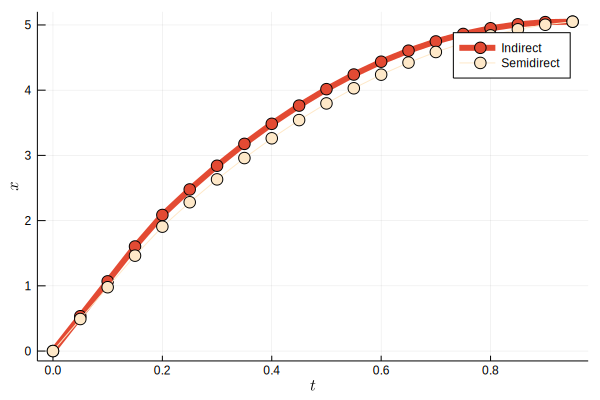

In [18]:
j = 1
xlabel=latexstring("t")
ylabel=latexstring("x")
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=6,ylabel=ylabel)

In [ ]:
savefig(string("slidingbox_x.svg")) 

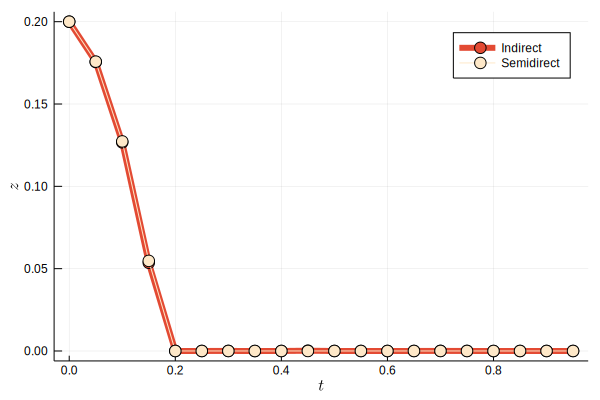

In [19]:
j = 2
xlabel=latexstring("t")
ylabel=latexstring("z")
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=6,ylabel=ylabel)

In [ ]:
savefig(string("slidingbox_z.svg")) 

In [ ]:
display(traj_indirect[2][1])
display(traj_semidirect[2][1])

In [ ]:
display(length(traj_indirect[9]))
display(length(traj_semidirect[9]))

# Trajectory optimization of little dog

In [ ]:
urdf = joinpath("..", "..", "urdf", "little_dog", "little_dog2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 100.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
open(mvis)

In [ ]:
N = 8
Δt = 0.025
q0 = [0., -.275, 0., 0., 0., 0., 0., pi/4, pi/4, -pi/4, -pi/4, -pi/2, -pi/2, pi/2, pi/2] 
v0 = zeros(num_velocities(mechanism))

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj_sim = Bilevel.simulate(sim_data,null_ctrl!,x0,N)
setanimation!(mvis, traj_sim[6], traj_sim[1])

In [ ]:
q_nom = copy(traj_sim[1][end])
q_min = min.(q_nom, [-5., -.5, -.2*pi, 0., 0., 0., 0., -3.5, -3.5, -3.5, -3.5, -3.1, -3.1, -3.1, -3.1])
q_max = max.(q_nom, [5., -0.1, .2*pi, 0., 0., 0., 0., 2.4, 2.4, 2.4, 2.4, 1., 1., 1., 1.])

x_goal = 0.05

N = 10
Δt = 0.1

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, 2, x -> vs(x, :q1)[1:2] - q_nom[1:2])
    add_eq!(sim_data, :cv1, num_velocities(mechanism), x -> vs(x, :v1))
    add_ineq!(sim_data, :cqNx, 1, x -> x_goal - vs(x, Symbol("q", N))[1])
    add_eq!(sim_data, :cqNlegs, num_positions(mechanism)-1, x -> vs(x, Symbol("q", N))[2:end] - vs(x, :q1)[2:end])
    add_eq!(sim_data, :cvN, num_velocities(mechanism), x -> vs(x, Symbol("v", N)))
end

function add_prob_obj!(sim_data)
    for n = 1:N-1
        add_obj!(sim_data, Symbol("u", n), x -> sim_data.vs(x, Symbol("u", n))' * sim_data.vs(x, Symbol("u", n)))
    end
end

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    u_limit = 10.
    add_box_con_snopt!(x_min, x_max, sim_data, :u, -u_limit * ones(num_velocities(mechanism)), u_limit * ones(num_velocities(mechanism)), 1:N-1)
    
    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        qn = copy(q_nom)
        qn[1] = (n/N)*(x_goal - q_nom[1]) + q_nom[1]
        x0[sim_data.vs(Symbol("q", n))] .= qn
    end
    
    x0
end

function setup_prob!(sim_data)
    add_prob_constraints!(sim_data)
    add_prob_obj!(sim_data)
    x_min, x_max = get_prob_limits(sim_data)
    x0 = get_prob_init(sim_data)
    
    x0, x_min, x_max
end

In [ ]:
# Indirect

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

display(@time traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_indirect[9]

setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [ ]:
setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
t_step = traj_indirect[7]
q_step = traj_indirect[1]
u_step = traj_indirect[2][2:end];

In [ ]:
# Semidirect

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

display(@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_semidirect[9]

setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [ ]:
set_configuration!(mvis, traj_semidirect[1][10])

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [ ]:
maximum(abs.(vcat(traj_semidirect[3]...)))

In [ ]:
cntraj = hcat(traj_semidirect[5]...)
front_traj = cntraj[1,:] .+ cntraj[2,:]
back_traj = cntraj[3,:] .+ cntraj[4,:];

In [ ]:
xlabel=latexstring("t")
ylabel=latexstring("c_n")
plot(traj_semidirect[7][1:end-1],front_traj,label="Front legs",seriescolor=RGB(((227,174,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7][1:end-1],back_traj,label="Back legs",seriescolor=RGB(((154,132,200) ./ 255.)...),linewidth=6,marker=6,ylabel=ylabel)

In [ ]:
savefig(string("littledog.svg")) 

In [ ]:
xlabel=latexstring("x")
ylabel=latexstring("z")
plot(traj_semidirect[8][1,:],-traj_semidirect[8][2,:],front_traj,label="Torso center of mass position",seriescolor=RGB(((127,174,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel,ylabel=ylabel)

In [ ]:
savefig(string("littledogcom.svg")) 

In [ ]:
setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [ ]:
t_step = traj_semidirect[7]
q_step = traj_semidirect[1]
u_step = traj_semidirect[2][2:end];

In [ ]:
# Multi-steps

reps = 5

ttraj = t_step
qtraj = q_step
utraj = u_step
for i = 1:(reps-1)
    ttraj = vcat(ttraj, t_step .+ ttraj[end])
    qtraj = vcat(qtraj, map(q -> q + vcat(qtraj[end][1],zeros(length(q)-1)), q_step))
    utraj = vcat(utraj, u_step)
end

setanimation!(mvis, ttraj, qtraj)